## Install Dependencies

In [1]:
# attendance kernel
# Python 3.6
# Tensorflow
# opencv
# matplotlib

In [2]:
# !pip install tensorflow==2.4.1 opencv-python matplotlib

## Import Dependencies

In [3]:
# Siamese neural network - explain during presentation
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# import tensorflow dependencies - functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [3]:
# setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

### Collect positives and anchors

In [ ]:
# http://vis-www.cs.umass.edu/lfw/ to download dataset
# uncompress tar GZ Labelled Faces in the wild dataset
!tar -xf lfw.tar # this extracts it into the same place it's in

In [ ]:
# move LFW images to data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### Collect positive and anchor classes - neg images are 250px by 250px

In [4]:
# import uuid library to generate unique image names
import uuid

In [ ]:
# access webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # cut frame to 250+250
    frame = frame[200:200+250,700:700+250, :]
    
    # collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) # unique file path
        cv2.imwrite(imgname, frame) # write image
    
    # collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame) # write image
    
    cv2.imshow('Image Collection', frame) # show img to screen
    
    if cv2.waitKey(1) & 0XFF == ord('q'): # break gracefully, q closes down frame
        break
cap.release() # release webcam
cv2.destroyAllWindows() # close image show frame

In [ ]:
plt.imshow(frame)

In [ ]:
frame.shape # need 250x250

In [ ]:
plt.imshow(frame[:250,:250,:]) # top left corner...

In [ ]:
plt.imshow(frame[200:200+250,700:700+250, :]); # found it

In [ ]:
# after fix
plt.imshow(frame)

### get image directories

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [6]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Convolution2D(32, 3, 3, input_shape = (64, 64, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))# sigmoid for binary

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('data/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('data/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 1885 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [9]:
history = classifier.fit_generator(training_set,
                         steps_per_epoch = 200,
                         epochs = 5,
                         validation_data = test_set)

Epoch 1/5
200/200 [==============================] - 14s 72ms/step - loss: 5.5245e-04 - accuracy: 1.0000 - val_loss: 3.8404e-04 - val_accuracy: 1.0000
Epoch 2/5
200/200 [==============================] - 15s 73ms/step - loss: 1.4850e-04 - accuracy: 1.0000 - val_loss: 2.7665e-04 - val_accuracy: 1.0000
Epoch 3/5
200/200 [==============================] - 14s 72ms/step - loss: 1.3050e-04 - accuracy: 1.0000 - val_loss: 4.2979e-04 - val_accuracy: 1.0000
Epoch 4/5
200/200 [==============================] - 17s 83ms/step - loss: 1.1436e-04 - accuracy: 1.0000 - val_loss: 2.1441e-04 - val_accuracy: 1.0000
Epoch 5/5
200/200 [==============================] - 14s 72ms/step - loss: 1.1497e-04 - accuracy: 1.0000 - val_loss: 7.1756e-05 - val_accuracy: 1.0000


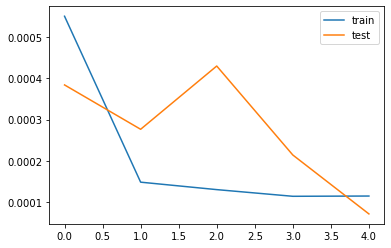

In [10]:
from matplotlib import pyplot as plt
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image
# loading an image from the disk
test_image = image.load_img('louis5.jpg', target_size = (64, 64))
# converting the image to a numpy array
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
# print(training_set.class_indices)
# our cut-off
if result[0][0] >= 0.5:
    prediction = 'notlouis'
else:
    prediction = 'louis'
print(prediction)
print(result)

louis
[[0.]]
